In [1]:
using CSV, DataFrames, PyPlot, ScikitLearn, Random
using StatsBase
using Statistics
# support vector classifier
@sk_import svm : SVC
# K-folds cross validation
using ScikitLearn.CrossValidation: KFold

## read in the data
The source of the data is [here](https://archive.ics.uci.edu/ml/datasets/Wine).

Each row of `wine_data.csv` represents measurements on a different bottle of wine-- one of two varieties. The three columns are:
* `class`: the label, i.e. what variety/class of wine it is. the label is not explicitly given, but think: Pinot Noir (-1) vs. Syrah (1).
* `alcohol`: the first feature, percent alcohol in the wine
* `malic_acid`: the second feature, malic acid concentration in the wine

In [2]:
df = CSV.read("wine.csv", copycols=true)
first(df, 5)

,class,alcohol,malic_acid
,Int64,Float64,Float64
1,-1,12.37,0.94
2,-1,12.33,1.1
3,-1,12.64,1.36
4,-1,13.67,1.25
5,-1,12.37,1.13


In [3]:
by(df, :class, total = :class => length) 

,class,total
,Int64,Int64
1,-1,71
2,1,48


how many wines are in each class?

Total = 119

Pinot Noir (-1) = 71

Syrah (1) = 48 

## visualize the data

draw a scatter plot of the data scattered in 2D feature space. color each data point by the class label. use hollow circles to help see points that are overlapping.

In [4]:
# Assign wine classes to a color 
color_scheme = Dict(-1 => "r", 1 => "g")

Dict{Int64,String} with 2 entries:
  -1 => "r"
  1  => "g"

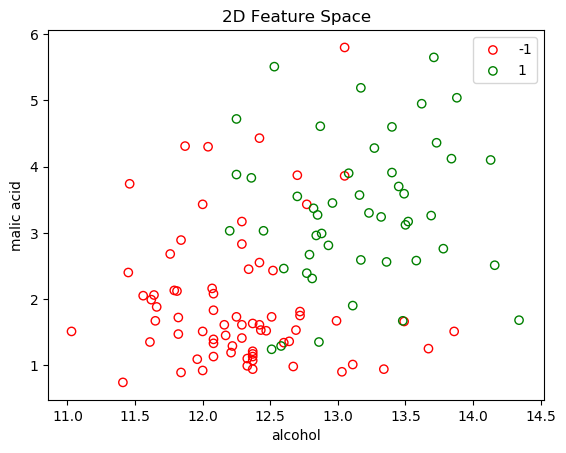

PyObject <matplotlib.legend.Legend object at 0x000000003957BA58>

In [5]:
figure()
xlabel("alcohol")
ylabel("malic acid")
for df_c in groupby(df, :class)
    outcome = df_c[1, :class]
    scatter(df_c[:, :alcohol], df_c[:, :malic_acid], label="$outcome", 
        marker="o", facecolor="None", edgecolor=color_scheme[outcome])
end
# scatter(df[:, :alcohol],df[:, :malic_acid], facecolor="None", edgecolor=["blue", "green","red"], label = "yes")
title("2D Feature Space")
legend()

## getting data ready for input to scikitlearn

to build a predictive model in scikitlearn:
* construct a feature matrix `X` that has `n_wines` rows and `2` columns (one column for each feature)
* construct a column vector `y` with the labels

loop through the rows of the wine `DataFrame` and populate each entry of the feature matrix `X` and target vector `y` with appropriate values

In [6]:
n_wines = nrow(df) # 119

X = zeros(n_wines, 2) # 2 features = alcohol and malic acid 
y = zeros(n_wines) # labels = wines 

for (i,wine) in enumerate(eachrow(df))
    X[i,1] = wine[:alcohol]
    X[i,2] = wine[:malic_acid]
    y[i] = wine[:class]
end
X # [alcoho malic_acid]

119×2 Array{Float64,2}:
 12.37  0.94
 12.33  1.1 
 12.64  1.36
 13.67  1.25
 12.37  1.13
 12.17  1.45
 12.37  1.21
 13.11  1.01
 12.37  1.17
 13.34  0.94
 12.21  1.19
 12.29  1.61
 13.86  1.51
  ⋮         
 13.45  3.7 
 12.82  3.37
 13.58  2.58
 13.4   4.6 
 12.2   3.03
 12.77  2.39
 14.16  2.51
 13.71  5.65
 13.4   3.91
 13.27  4.28
 13.17  2.59
 14.13  4.1 

## training a support vector machine (SVM)

train a support vector machine to classify wines using *all* of the data. evaluate the accuracy on the training data. we'll later show through cross-validation that this is an overestimate of the true accuracy of the SVM classifier on unseen data. use `C=1.0`. use the linear kernel. [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) is the documentation for the `SVC` function (Support Vector Classifier) in scikitlearn.

```julia
# use a linear kernel
clf = SVC(kernel="linear", C=1.0)
```

In [7]:
clf = SVC(kernel="linear", C=1.0)
clf.fit(X,y) # this will train the data, we can then predict new unseen data

PyObject SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## visualize the decision boundary

draw the decision boundary (in feature space) learned by the SVM trained on test data. Also plot the data in feature space (with the decision boundary) with different colors/symbols for the different classes (exactly as in `# visualize the data`). hint: follow the class notes for k-nearest neighbors, using `contourf`, but this is not the only way.

In [8]:
# want to find the mean of all classes 
by(df, :class, mean_alcohol=:alcohol=>mean, mean_acid=:malic_acid=>mean)

,class,mean_alcohol,mean_acid
,Int64,Float64,Float64
1,-1,12.2787,1.93268
2,1,13.1537,3.33375


In [9]:
# want to find the max/min of all classes 
by(df, :class, max_alcohol=:alcohol=>maximum, min_alcohol=:alcohol=>minimum, max_malic=:malic_acid=>maximum, min_malic=:malic_acid=>minimum)

,class,max_alcohol,min_alcohol,max_malic,min_malic
,Int64,Float64,Float64,Float64,Float64
1,-1,13.86,11.03,5.8,0.74
2,1,14.34,12.2,5.65,1.24


In [10]:
# test predictions on averages 
test_pinot = [12.2787 1.93268]   # -1
test_syrah = [13.1537 3.33375]   #  1
println(clf.predict(test_pinot))
println(clf.predict(test_syrah))

[-1.0]
[1.0]


In [11]:
alcohol = 11:0.1:14.5 # min->max 
malic_acid= 0:.1:6 # min->max 

svm_predictions = zeros(length(malic_acid), length(alcohol))
for i = 1:length(alcohol)
    for j = 1:length(malic_acid)
        x =[alcohol[i] malic_acid[j]]
        svm_predictions[j,i] = clf.predict(x)[1]
    end
end
# svm_predictions

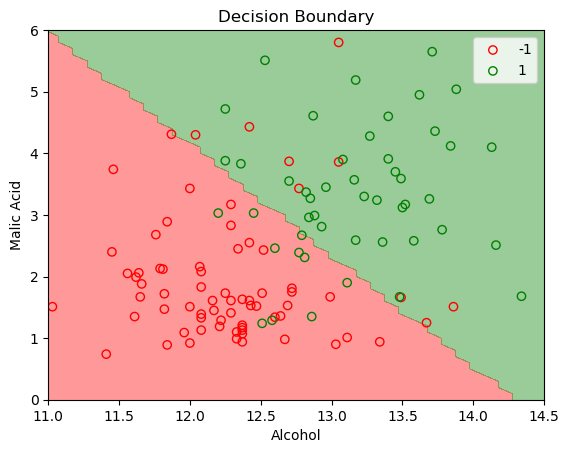

PyObject <matplotlib.legend.Legend object at 0x00000000010260B8>

In [20]:
figure()
# contour([X, Y,] Z, [levels], **kwargs) -> https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html
contourf(alcohol, malic_acid, svm_predictions, alpha=0.4, [-1.0,0.5,2.0], colors=["r","g"])
for df_p in groupby(df, :class)
    outcome = df_p[1, :class]
    scatter(df_p[:, :alcohol], df_p[:,:malic_acid],facecolor="None", edgecolor=color_scheme[outcome], label=outcome)
end
title("Decision Boundary")
xlabel("Alcohol")
ylabel("Malic Acid")
legend()

## $K=5$-fold cross validation
use $K=5$-fold cross validation to:
* choose the optimal `C` parameter in the SVM classifier
* assess the accuracy of the model on unseen data

plot the average test set accuracy (average over the $K$ folds) against the `C` parameter used.

report the best `C` parameter and the associated average test set error (`argmax` might be useful). This test set error is a quality metric of how well the SVM will perform on new, unseen data that is not in the training set. explore the following set of `C` parameters: `c_params = 10.0 .^ range(-3, stop=0, length=25)`. 

In [13]:
K = 5 # number of folds
c_params = 10.0 .^ range(-3, stop=0, length=25) # 5-element Array{Float64,1}
kf = KFold(n_wines, n_folds=K, shuffle=true)
c_params = 10.0 .^ range(-3, stop=0, length=25)
length(c_params) # 25
test_accuracy = zeros(length(c_params))

for c = 1:length(c_params)
    for (train_ids, test_ids) in kf
        clf = SVC(kernel="linear", C=c_params[c])
        clf.fit(X[train_ids,:], y[train_ids])
        y_pred = clf.predict(X[test_ids, :])
#         test_accuracy[c] += sum(y_pred .== y[test_ids])/length(test_ids)
        test_accuracy[c] += clf.score(X[test_ids,:],y[test_ids])
    end
    test_accuracy[c] /= K
end

In [14]:
using Printf

opt_c = c_params[argmax(test_accuracy)] # 0.042169650342858224
# realized ... argmax(test_accuracy) = 14, bottom line is not necessary 
index_opt_c = findall(x->x==opt_c, c_params) # 14 - find index of opt_c in c_params array 
opt_test_accuracy = test_accuracy[index_opt_c][1]  #0.8409420289855072

0.8402173913043478

In [15]:
best_score = clf.fit(X, y).score(X, y) # does not consider K_folds? 

0.8403361344537815

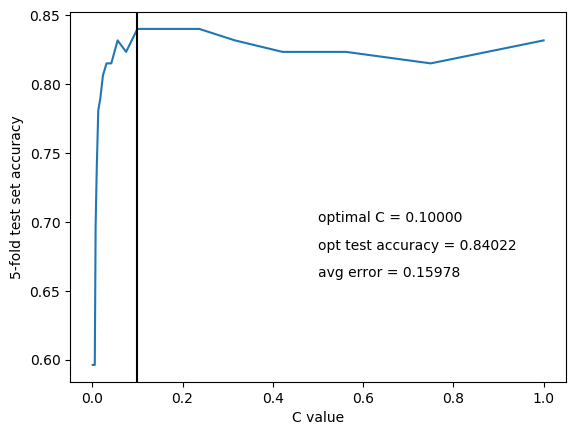

optimal c = 0.1
test accuracy: 0.8402173913043478


PyObject Text(0.5, 24.0, 'C value')

In [16]:
figure()
plot(c_params, test_accuracy)
println("optimal c = ", opt_c)
println("test accuracy: ", opt_test_accuracy)
axvline(opt_c, color = "k")
text(0.5,0.7, @sprintf("optimal C = %.5f", opt_c))
text(0.5,0.68, @sprintf("opt test accuracy = %.5f", opt_test_accuracy))
text(0.5,0.66, @sprintf("avg error = %.5f", 1-opt_test_accuracy))
ylabel("5-fold test set accuracy")
xlabel("C value")

my conclusion:

The optimal c value varies a bit if I run the program multiple times but the optimal test accuracy and average error stays relatively the same. This is probably because of the shuffle function in the KFold that allows for variation.